<a href="https://colab.research.google.com/github/sodiq-sulaimon/Preparations-for-TensorFlow-Developer-Certification/blob/main/Time_Series/Using_a_multilayer_LSTM_for_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

### Utilities

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
  """
  Visualizes time series data

    Args:
      time (array of int) - contains the time steps
      series (array of int) - contains the measurements for each time step
      format - line style when plotting the graph
      start - first time step to plot
      end - last time step to plot
  """
  # Setup dimensions of the graph figure
  plt.figure(figsize=(10, 6))

  if type(series) is tuple:
    for series_num in series:
      plt.plot(time[start:end], series_num[start:end], format)

  else:
    plt.plot(time[start:end], series[start:end], format)

  plt.xlabel("Time")
  plt.ylabel("Value")

  plt.grid(True)
  plt.show()

def trend(time, slope=0):
  """
    Generates synthetic data that follows a straight line given a slope value.

    Args:
      time (array of int) - contains the time steps
      slope (float) - determines the direction and steepness of the line

    Returns:
      series (array of float) - measurements that follow a straight line
    """
    # Compute the linear series given the slope
  series = slope * time

  return series

def seasonal_pattern(season_time):
  """
    Just an arbitrary pattern

    Args:
      season_time (array of float) - contains the measurements per time step

    Returns:
      data_pattern (array of float) -  contains revised measurement values according
                                  to the defined pattern
    """
    # Generate the values using an arbitrary pattern
  data_pattern = np.where(season_time < 0.4,
                            np.cos(season_time * 2 * np.pi),
                            1 / np.exp(3 * season_time))
  return data_pattern

def seasonality(time, period, amplitude, phase=0):
  """
    Repeats the same pattern at each period

    Args:
      time (array of int) - contains the time steps
      period (int) - number of time steps before the pattern repeats
      amplitude (int) - peak measured value in a period
      phase (int) - number of time steps to shift the measured values

    Returns:
      data_pattern (array of float) - seasonal data scaled by the defined amplitude
    """
  # Define the measured value per period
  season_time = ((time + phase) % period) / period

  # Generates the seasonal data scaled by the defined amplitude
  data_pattern = amplitude * seasonal_pattern(season_time)

  return data_pattern

def noise(time, noise_level=1, seed=None):
  """Generates a normally distributed noisy signal

    Args:
      time (array of int) - contains the time steps
      noise_level (float) - scaling factor for the generated signal
      seed (int) - number generator seed for repeatability

    Returns:
      noise (array of float) - the noisy signal
    """
  # Initialize the random number generator
  rnd = np.random.RandomState(seed)

  # Generate a random number for each time step and scale by the noise level
  noise = rnd.randn(len(time)) * noise_level

  return noise


### Generate the synthetic data

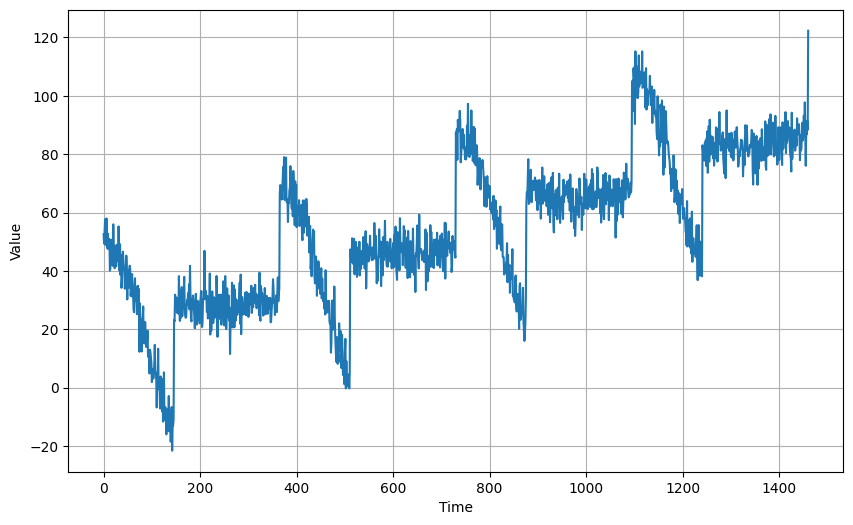

In [3]:
# Parameters
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Update with noise
series += noise(time, noise_level, seed=42)

# Plot the results
plot_series(time, series)

### Split the dataset

In [4]:
split_time = 1000

# Get the train set
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

### Prepare the features and labels

In [5]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """
  # Generate a TF Dataset from the series values
  dataset = tf.data.Dataset.from_tensor_slices(series)

  # Window the dataset
  dataset = dataset.window(size=window_size+1, shift=1, drop_remainder=True)# Plus 1 accounts for the label

  # Flatten the windows by putting its element in a single batch
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

  # Create tuple of features and labels
  dataset = dataset.map(lambda window: (window[:-1], window[-1]))

  # Shuffle the dataset
  dataset = dataset.shuffle(shuffle_buffer)

  # Batch the dataset
  dataset = dataset.batch(batch_size).prefetch(1)

  return dataset

In [7]:
# Generate the dataset windows
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [8]:
# Print shapes of feature and label
for window in dataset.take(1):
  print(f'shape of feature: {window[0].shape}')
  print(f'shape of label: {window[1].shape}')

shape of feature: (32, 20)
shape of label: (32,)


### Build the model

In [9]:
model_tune = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[window_size]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

model_tune.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 20, 1)             0         
                                                                 
 bidirectional (Bidirection  (None, 20, 64)            8704      
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                24832     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
 lambda_1 (Lambda)           (None, 1)                 0         
                                                                 
Total params: 33601 (131.25 KB)
Trainable params: 33601 

### Tune the learning rate

In [10]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model_tune.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model_tune.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 21s 17ms/step - loss: 54.8346 - lr: 1.0000e-08
Epoch 2/100
31/31 [==============================] - 1s 10ms/step - loss: 52.9653 - lr: 1.1220e-08
Epoch 3/100
31/31 [==============================] - 0s 9ms/step - loss: 50.6561 - lr: 1.2589e-08
Epoch 4/100
31/31 [==============================] - 0s 9ms/step - loss: 47.8724 - lr: 1.4125e-08
Epoch 5/100
31/31 [==============================] - 0s 9ms/step - loss: 44.5687 - lr: 1.5849e-08
Epoch 6/100
31/31 [==============================] - 0s 8ms/step - loss: 38.9946 - lr: 1.7783e-08
Epoch 7/100
31/31 [==============================] - 0s 10ms/step - loss: 20.7029 - lr: 1.9953e-08
Epoch 8/100
31/31 [==============================] - 0s 9ms/step - loss: 17.0950 - lr: 2.2387e-08
Epoch 9/100
31/31 [==============================] - 0s 10ms/step - loss: 16.8345 - lr: 2.5119e-08
Epoch 10/100
31/31 [==============================] - 0s 9ms/step - loss: 16.5315 - lr: 2.8184e-08
Epoch 11/100
3

Visualize the result and pick the optimal learning rate

(1e-08, 0.001, 0.0, 50.0)

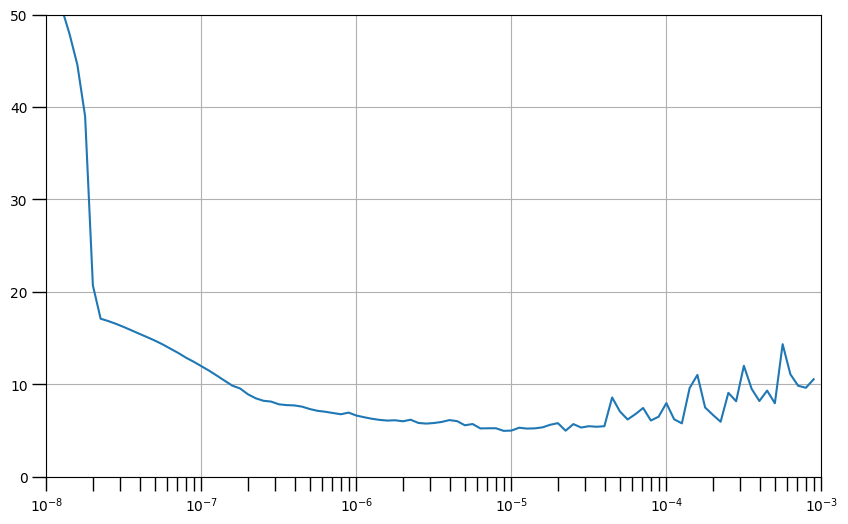

In [11]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 50])

We can change the boundaries of the graph  to zoom in. The cell below chooses a narrower range so we can see more clearly where the graph becomes unstable.

(1e-07, 0.0001, 0.0, 20.0)

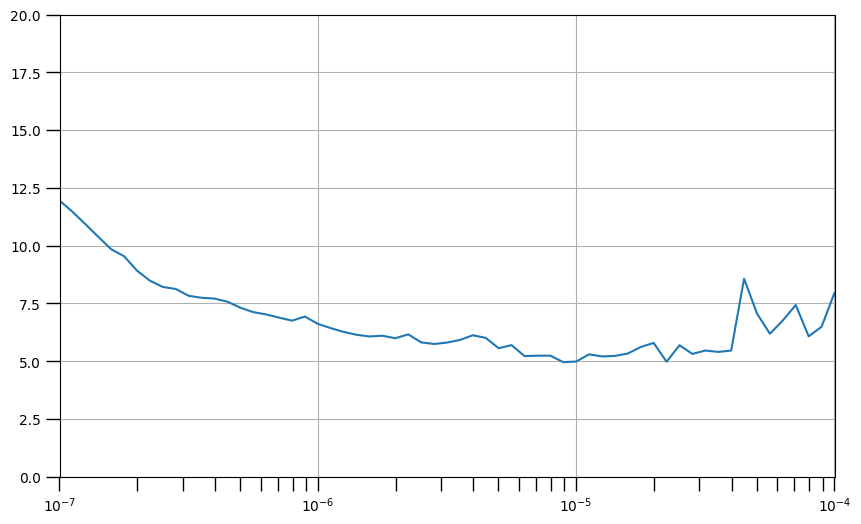

In [12]:
# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-7, 1e-4, 0, 20])

### Train the model

In [13]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[window_size]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

model.compile(loss=tf.keras.losses.Huber(),
                   optimizer=tf.keras.optimizers.SGD(learning_rate=2e-6, momentum=0.9))

# Train the model
history = model.fit(dataset, epochs=100)

Epoch 1/100
31/31 [==============================] - 6s 9ms/step - loss: 25.8693
Epoch 2/100
31/31 [==============================] - 0s 9ms/step - loss: 9.6632
Epoch 3/100
31/31 [==============================] - 0s 8ms/step - loss: 7.3167
Epoch 4/100
31/31 [==============================] - 0s 8ms/step - loss: 6.3875
Epoch 5/100
31/31 [==============================] - 0s 9ms/step - loss: 6.1207
Epoch 6/100
31/31 [==============================] - 0s 8ms/step - loss: 5.8692
Epoch 7/100
31/31 [==============================] - 0s 9ms/step - loss: 5.6477
Epoch 8/100
31/31 [==============================] - 0s 8ms/step - loss: 5.4803
Epoch 9/100
31/31 [==============================] - 0s 10ms/step - loss: 5.4240
Epoch 10/100
31/31 [==============================] - 1s 12ms/step - loss: 5.3770
Epoch 11/100
31/31 [==============================] - 1s 12ms/step - loss: 5.3047
Epoch 12/100
31/31 [==============================] - 1s 12ms/step - loss: 5.1888
Epoch 13/100
31/31 [============

### Model Prediction

In [14]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    # Get predictions on the entire dataset
    forecast = model.predict(dataset)

    return forecast

15/15 [==============================] - 1s 6ms/step


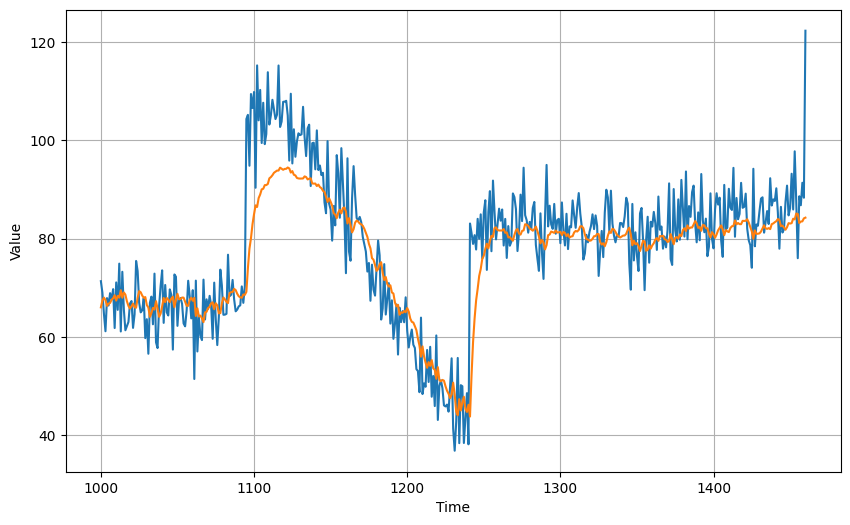

In [15]:
# Reduce the original series
forecast_series = series[split_time - window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [16]:
# Compute the MSE and MAE
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

62.343994
5.7239313


### Including a validation set while training

In [17]:
# Generate data windows of the validation set
val_set = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)

In [ ]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Build the model
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Set the learning rate
learning_rate = 2e-6

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(dataset,epochs=100, validation_data=val_set)

Epoch 1/100
31/31 [==============================] - 8s 57ms/step - loss: 21.3022 - mae: 21.7984 - val_loss: 30.8123 - val_mae: 31.3105
Epoch 2/100
31/31 [==============================] - 0s 12ms/step - loss: 11.5586 - mae: 12.0498 - val_loss: 20.1314 - val_mae: 20.6297
Epoch 3/100
31/31 [==============================] - 0s 12ms/step - loss: 8.0678 - mae: 8.5477 - val_loss: 14.9484 - val_mae: 15.4452
Epoch 4/100
31/31 [==============================] - 0s 12ms/step - loss: 7.2486 - mae: 7.7254 - val_loss: 11.9231 - val_mae: 12.4126
Epoch 5/100
31/31 [==============================] - 0s 12ms/step - loss: 7.0082 - mae: 7.4905 - val_loss: 10.9780 - val_mae: 11.4669
Epoch 6/100
31/31 [==============================] - 1s 14ms/step - loss: 6.8736 - mae: 7.3573 - val_loss: 12.1415 - val_mae: 12.6348
Epoch 7/100
31/31 [==============================] - 0s 12ms/step - loss: 6.7338 - mae: 7.2153 - val_loss: 9.6822 - val_mae: 10.1735
Epoch 8/100
31/31 [==============================] - 0s 12m